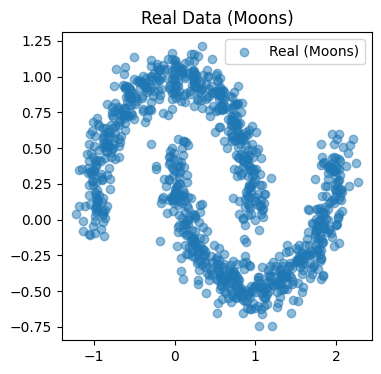

Epoch    0 | D_loss: -1.5652 | G_loss: -0.5008
Epoch  100 | D_loss: -1.7199 | G_loss: -0.5414
Epoch  200 | D_loss: -1.6895 | G_loss: -0.5502
Epoch  300 | D_loss: -1.5665 | G_loss: -0.5434
Epoch  400 | D_loss: -1.4488 | G_loss: -0.4797
Epoch  500 | D_loss: -1.5725 | G_loss: -0.6250
Epoch  600 | D_loss: -1.4299 | G_loss: -0.5666
Epoch  700 | D_loss: -1.4094 | G_loss: -0.5794
Epoch  800 | D_loss: -1.4930 | G_loss: -0.6043
Epoch  900 | D_loss: -1.5054 | G_loss: -0.5121
Epoch 1000 | D_loss: -1.3335 | G_loss: -0.6143
Epoch 1100 | D_loss: -1.4291 | G_loss: -0.5747
Epoch 1200 | D_loss: -1.3848 | G_loss: -0.5843
Epoch 1300 | D_loss: -1.5156 | G_loss: -0.6374
Epoch 1400 | D_loss: -1.4499 | G_loss: -0.6660
Epoch 1500 | D_loss: -1.3562 | G_loss: -0.5772
Epoch 1600 | D_loss: -1.3572 | G_loss: -0.6016
Epoch 1700 | D_loss: -1.3494 | G_loss: -0.6388
Epoch 1800 | D_loss: -1.4004 | G_loss: -0.6679
Epoch 1900 | D_loss: -1.3606 | G_loss: -0.6595
Epoch 2000 | D_loss: -1.4288 | G_loss: -0.6523
Epoch 2100 | 

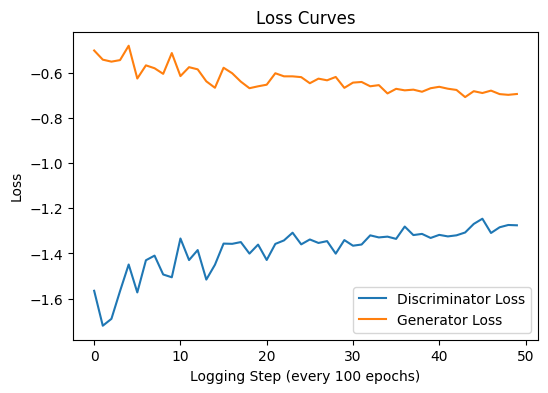

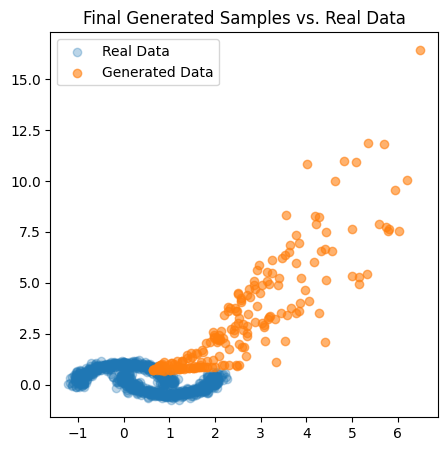

In [57]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from neural_network import ThreeLayerNN


class Generator:

    def __init__(self, z_dim=2, hidden_units=32, data_dim=2, 
                 learning_rate=0.0001, clip_value=2):
        self.z_dim = z_dim
        self.hidden_units = hidden_units
        self.data_dim = data_dim
        self.learning_rate = learning_rate
        self.clip_value = clip_value

        self.W1 = np.random.randn(self.z_dim, self.hidden_units) * np.sqrt(2.0 / z_dim)
        self.b1 = np.zeros((1, self.hidden_units))

        self.W2 = np.random.randn(self.hidden_units, self.data_dim) * np.sqrt(2.0 / self.hidden_units)
        self.b2 = np.zeros((1, self.data_dim))
        
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def forward(self, z):

        self.z_input = z

        self.z1 = np.dot(z, self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.output = self.z2
        
        return self.output

    def backward(self, grad_output):

        grad_output = np.clip(grad_output, -self.clip_value, self.clip_value)
        
        dW2 = np.dot(self.a1.T, grad_output)
        db2 = np.sum(grad_output, axis=0, keepdims=True)
        
        dA1 = np.dot(grad_output, self.W2.T)
        dZ1 = dA1 * self.relu_derivative(self.z1)
        
        dZ1 = np.clip(dZ1, -self.clip_value, self.clip_value)
        
        dW1 = np.dot(self.z_input.T, dZ1)
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        
        dW2 = np.clip(dW2, -self.clip_value, self.clip_value)
        db2 = np.clip(db2, -self.clip_value, self.clip_value)
        dW1 = np.clip(dW1, -self.clip_value, self.clip_value)
        db1 = np.clip(db1, -self.clip_value, self.clip_value)
        
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1

data_dim = 2
real_data, _ = make_moons(n_samples=1000, noise=0.1, random_state=42)

plt.figure(figsize=(4,4))
plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.5, label="Real (Moons)")
plt.title("Real Data (Moons)")
plt.legend()
plt.show()

z_dim = 2 
hidden_units = 8     
learning_rate = 0.0001
clip_value = 1.0


discriminator = ThreeLayerNN(
    input_dim=data_dim,
    hidden_units=hidden_units,
    output_dim=1,          
    learning_rate=learning_rate,
    clip_value=clip_value
)

generator = Generator(
    z_dim=z_dim,
    hidden_units=hidden_units,
    data_dim=data_dim,
    learning_rate=learning_rate,
    clip_value=clip_value
)

epochs = 5000
batch_size = 32

def sample_noise(batch_size, z_dim):
    return np.random.normal(0, 1, size=(batch_size, z_dim))

d_losses, g_losses = [], []

for epoch in range(epochs):

    idx = np.random.randint(0, len(real_data), batch_size)
    real_batch = real_data[idx]

    z = sample_noise(batch_size, z_dim)
    fake_batch = generator.forward(z)

    d_real = discriminator.forward(real_batch)
    d_fake = discriminator.forward(fake_batch)

    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))

    discriminator.backward(real_batch, y_real, d_real)
    discriminator.backward(fake_batch, y_fake, d_fake)

    z_gen = sample_noise(batch_size, z_dim)
    generated_samples = generator.forward(z_gen)
    d_generated = discriminator.forward(generated_samples)


    grad_gen = -1.0 / np.clip(d_generated, 1e-7, 1-1e-7)
    
    grad_gen_expanded = np.repeat(grad_gen, data_dim, axis=1)

    generator.backward(grad_gen_expanded)


    if epoch % 100 == 0:

        eps = 1e-7
        d_loss_real = np.mean(np.log(d_real + eps))
        d_loss_fake = np.mean(np.log(1 - d_fake + eps))
        d_loss = d_loss_real + d_loss_fake
        
        g_loss = np.mean(np.log(d_generated + eps))
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
        print(f"Epoch {epoch:4d} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")
        

plt.figure(figsize=(6,4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("Loss Curves")
plt.xlabel("Logging Step (every 100 epochs)")
plt.ylabel("Loss")
plt.legend()
plt.show()

z_test = sample_noise(200, z_dim)
samples = generator.forward(z_test)

plt.figure(figsize=(5,5))
plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.3, label='Real Data')
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6, label='Generated Data')
plt.title("Final Generated Samples vs. Real Data")
plt.legend()
plt.show()
